# Sine wave extrapolation

In [1115]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset,TensorDataset

import matplotlib.pyplot as plt

# Crate dataset 

In [1116]:
# y = sin(t+cos(t))
intervall = (0,np.pi*30)
N = 500
x = np.linspace(intervall[0],intervall[1],N)
y = np.sin(x+np.cos(x))
y.shape

(500,)

/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_10957/819929895.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(y,'ks-', color='cyan',markerfacecolor='r')


(-5.0, 550.0)

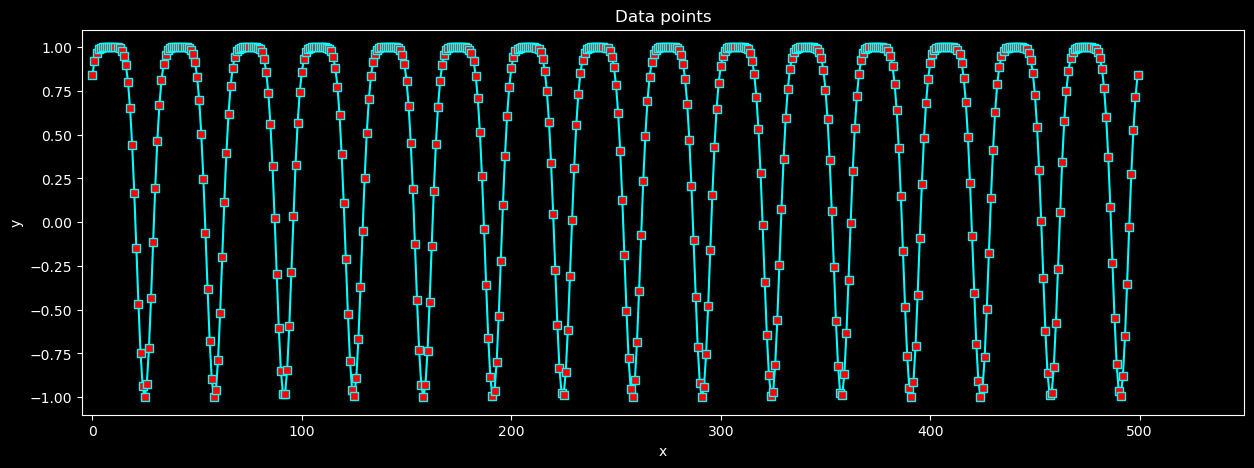

In [1117]:
fig = plt.figure(facecolor='black',figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.set_facecolor('black')
ax.plot(y,'ks-', color='cyan',markerfacecolor='r')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
ax.set_title('Data points', color='white')
ax.set_xlabel('x', color='white')
ax.set_ylabel('y', color='white')    
ax.set_xlim([-5,N+50])

/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_10957/240106725.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(y[:30],'ks-', color='cyan',markerfacecolor='r')


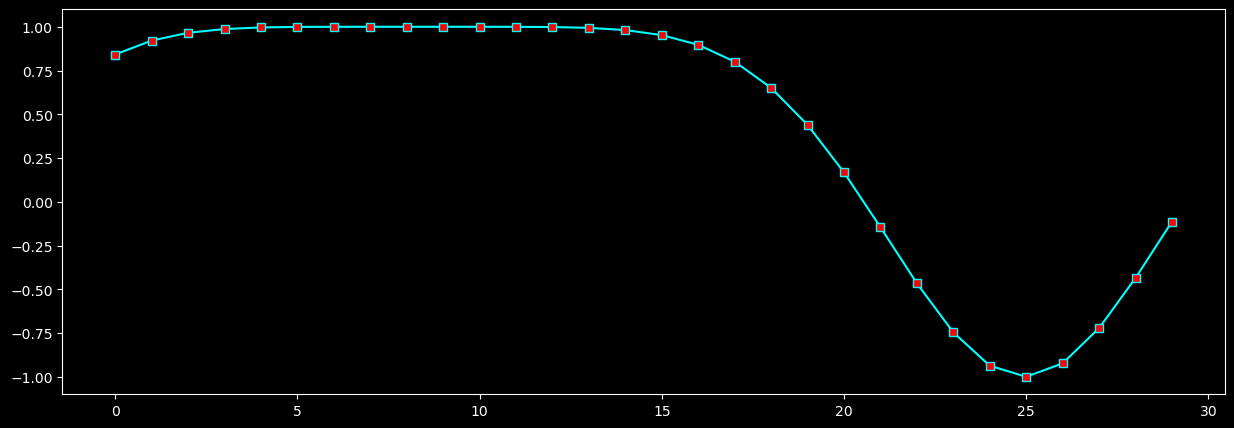

In [1118]:
# is the sequence long enough to understand the trend?

fig = plt.figure(facecolor='black',figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.set_facecolor('black')
ax.plot(y[:30],'ks-', color='cyan',markerfacecolor='r')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

In [1119]:
data = torch.from_numpy(y).float()
data.shape

torch.Size([500])

In [1120]:
data = data.unsqueeze(-1) # add the feature dimension
data.shape

torch.Size([500, 1])

In [1121]:
seq_length = 30
batch_size = 3
input_size = 1
hidden_size = 10
num_layers = 1

In [1122]:
def make_sliding_windows(data, seq_len):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        Y.append(data[i + seq_len ])
    return torch.stack(X), torch.stack(Y)

In [1123]:
slieded_X, slieded_y = make_sliding_windows(data, seq_length)

slieded_X.shape, slieded_y.shape

(torch.Size([470, 30, 1]), torch.Size([470, 1]))

In [1124]:
dataset = TensorDataset(slieded_X, slieded_y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [1125]:
x1,y1 = next(iter(loader))
x1.shape,y1.shape

(torch.Size([3, 30, 1]), torch.Size([3, 1]))

# Modeling

In [1126]:
class RNNnet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,batch_size):
        super().__init__()

        # store parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        # define the RNN
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,batch_first=True)

        # linear layer for output
        self.out = nn.Linear(hidden_size, 1)
    def forward(self, x):

        

        # initialize the hidden state for the first input


        hidden = torch.zeros(self.num_layers,x.size(0),self.hidden_size,device=x.device)  
       

        # run through the RNN layer
        y,hidden = self.rnn(x,hidden)  
        

        # pass the RNN output through the linear output layer 
        o = self.out(y)
      

        return o,hidden

In [1127]:
model = RNNnet(input_size, hidden_size, num_layers,batch_size)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

RNNnet(
  (rnn): RNN(1, 10, batch_first=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

# Train the model

In [1128]:
def trainRNN(model:RNNnet,lossFun,optimizer,num_epochs ,loader,device='mps'):

    losses = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        # switch to train mode
        model.train()

        batch_loss = []

        # loop over training data in batches
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            # forward pass and loss
            y_pred, _ = model(X)  # y_pred: [batch_size, seq_length, 1]
            y_pred = y_pred[:,-1,:]
            
            
            loss = lossFun(y_pred, y)  # y: [batch_size, seq_length, 1]

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batch_loss.append(loss.item())
            


        losses[epoch] = np.mean(batch_loss)
        print(f'Epoch {epoch} | Loss: {losses[epoch]:.4f}')
        

    return losses        
         

In [1129]:
lossFun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [1130]:
losses = trainRNN(model,lossFun,optimizer,10,loader,device=device)

Epoch 0 | Loss: 0.3829
Epoch 1 | Loss: 0.0699
Epoch 2 | Loss: 0.0267
Epoch 3 | Loss: 0.0119
Epoch 4 | Loss: 0.0082
Epoch 5 | Loss: 0.0064
Epoch 6 | Loss: 0.0052
Epoch 7 | Loss: 0.0043
Epoch 8 | Loss: 0.0035
Epoch 9 | Loss: 0.0030


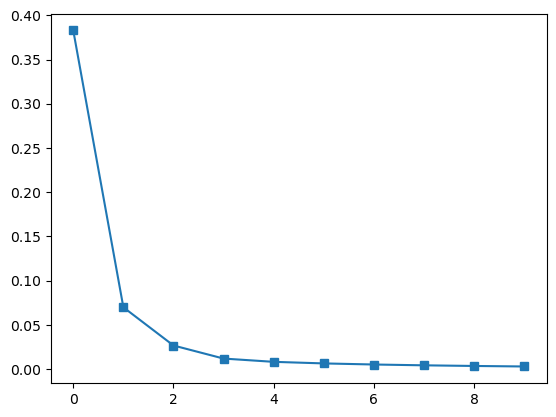

In [1131]:
plt.plot(losses,'s-')

# Discover the prediction proccess 

In [1132]:
x_tensor , y_tensor = next(iter(loader))
x_tensor.shape,y_tensor.shape

(torch.Size([3, 30, 1]), torch.Size([3, 1]))

In [1133]:
y_tensor[:,:]

tensor([[0.1973],
        [0.4632],
        [0.6686]])

In [1134]:
x_item = x_tensor[0] # first batch
y_item = y_tensor[0] # first batch prediction
x_item.shape,y_item.shape , x[0:2]

(torch.Size([30, 1]), torch.Size([1]), array([0.        , 0.18887331]))

In [1135]:
x_item = x_item[0] # first time step of the first batch
y_item = y_item[0] # first time step prediction (second step cz we predict next step) of the first batch
x_item , y_item

(tensor([0.8415]), tensor(0.1973))

In [1136]:
first_pred = model(x_tensor.to(device))[0]

first_pred[:,0,0]

tensor([0.8014, 0.8702, 0.9078], device='mps:0', grad_fn=<SelectBackward0>)

In [1137]:
def plot_model_vs_original(model, loader, device='mps', seq_len=30):
    model.eval()

    total_samples = len(loader.dataset)
    yHat = np.zeros(total_samples + seq_len)

    with torch.no_grad():
        for i, (X, y) in enumerate(loader):
            X = X.to(device)

            model_pred = model(X)[0]  # [batch_size, seq_len, 1]
            
            preds = model_pred[:, -1, 0].cpu().numpy()  # [batch_size]

            start_idx = i * X.shape[0] + seq_len
            end_idx = start_idx + X.shape[0]
            yHat[start_idx:end_idx] = preds

    return yHat

In [1138]:
yHat = plot_model_vs_original(model, loader, device='mps')

/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_10957/50227432.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(y,'ks-', color='purple')
/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_10957/50227432.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  ax.plot(yHat,'ks', color='pink')


(-5.0, 550.0)

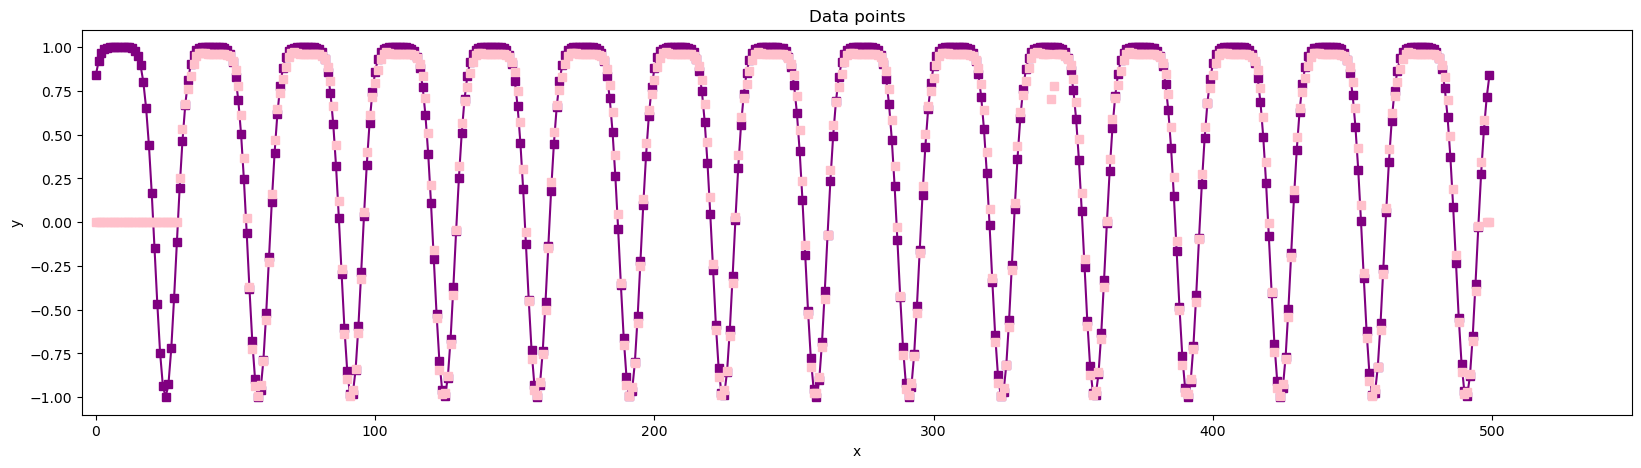

In [1139]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.plot(y,'ks-', color='purple')
ax.plot(yHat,'ks', color='pink')
ax.set_title('Data points')
ax.set_xlabel('x' )
ax.set_ylabel('y' )    
ax.set_xlim([-5,N+50])

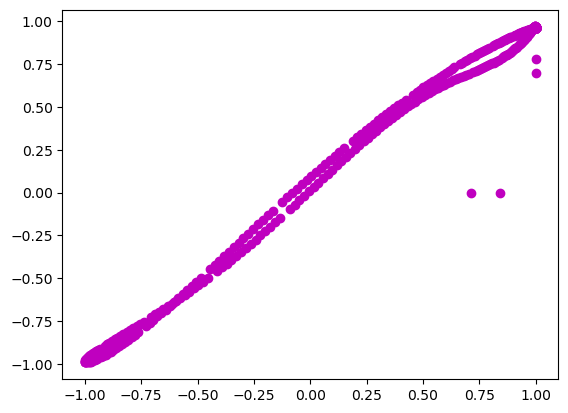

In [1140]:
plt.plot(y[seq_length:],yHat[seq_length:],'mo',)

# Test on new data

In [1141]:
time = torch.linspace(0,10*torch.pi,N)

new_data = torch.sin(time+torch.cos(time))
new_data = new_data.unsqueeze(-1) # add the feature dimension
data.shape

torch.Size([500, 1])

In [1142]:
slieded_X, slieded_y = make_sliding_windows(new_data, seq_length)
dataset = TensorDataset(slieded_X, slieded_y)
new_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [1143]:
new_x , new_y = next(iter(new_loader))
new_x.shape , new_y.shape

(torch.Size([3, 30, 1]), torch.Size([3, 1]))

/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_10957/3580338595.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(new_data,'ks-', color='purple')
/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_10957/3580338595.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  ax.plot(new_yhat,'ks', color='pink')


(-5.0, 550.0)

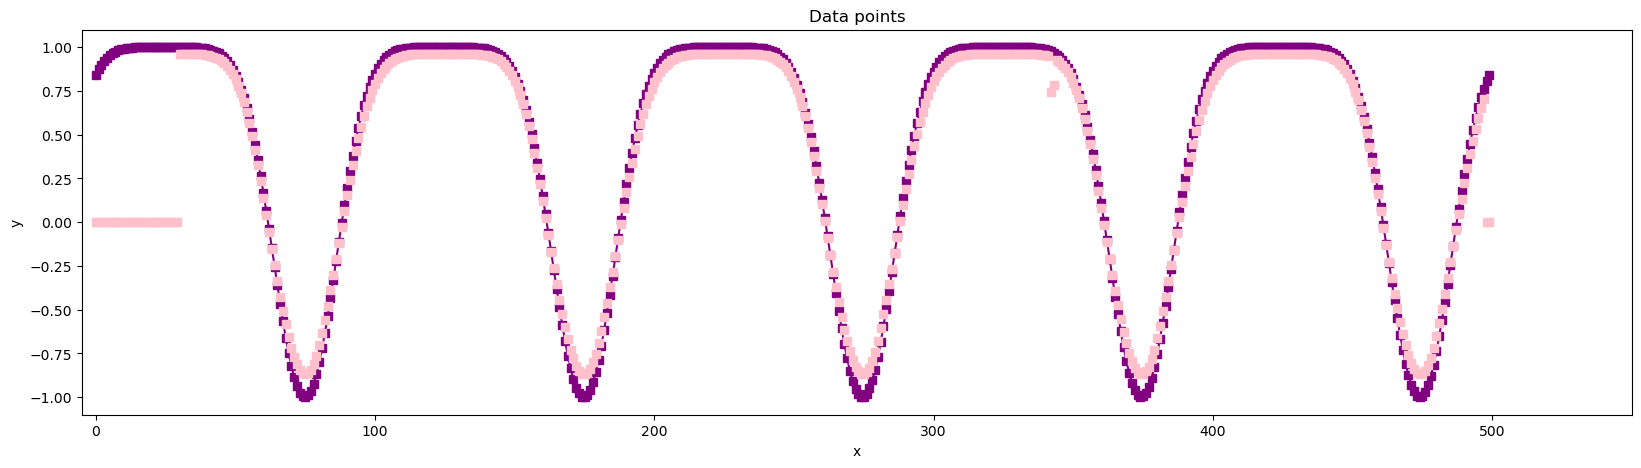

In [1144]:
new_yhat = plot_model_vs_original(model, new_loader, device='mps')
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.plot(new_data,'ks-', color='purple')
ax.plot(new_yhat,'ks', color='pink')
ax.set_title('Data points')
ax.set_xlabel('x' )
ax.set_ylabel('y' )    
ax.set_xlim([-5,N+50])

In [1164]:
def plot_model_vs_original(model, loader, device='mps', seq_len=30, extra_preds=100):
    model.eval()

    total_samples = len(loader.dataset)
    yHat = np.zeros(total_samples + extra_preds)
    all_data = []

    offset = 0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            model_pred = model(X)[0]  # [batch, seq_len, 1]
            preds = model_pred[:, -1, 0].cpu().numpy()
            all_data.append(X.cpu().numpy())

            yHat[offset + seq_len : offset + seq_len + X.shape[0]] = preds
            offset += X.shape[0]

    # Get last sequence from the last batch
    last_seq = all_data[-1][-1]  # shape [seq_len, 1]

    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(device)  # [1, seq_len, 1]

    # Predict future values
    future_input = last_seq.clone().detach()  # [1, seq_len, 1]

    for i in range(extra_preds):
        with torch.no_grad():
            pred = model(future_input)[0]  # [1, seq_len, 1]
            next_val = pred[:, -1, :]  # [1, 1]

        yHat[total_samples + i] = next_val.item()

        # Slide window forward
        future_input = torch.cat([future_input[:, 1:, :], next_val.unsqueeze(1)], dim=1)

    return yHat

In [1165]:
predicted_series = plot_model_vs_original(model, new_loader, device='mps',extra_preds=300)

/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_10957/926979970.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(new_data,'ks-', color='purple')
/var/folders/tn/ydlwf6sn6bb5ccy1g888k1q40000gn/T/ipykernel_10957/926979970.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  ax.plot(predicted_series,'ks', color='pink')


(-5.0, 550.0)

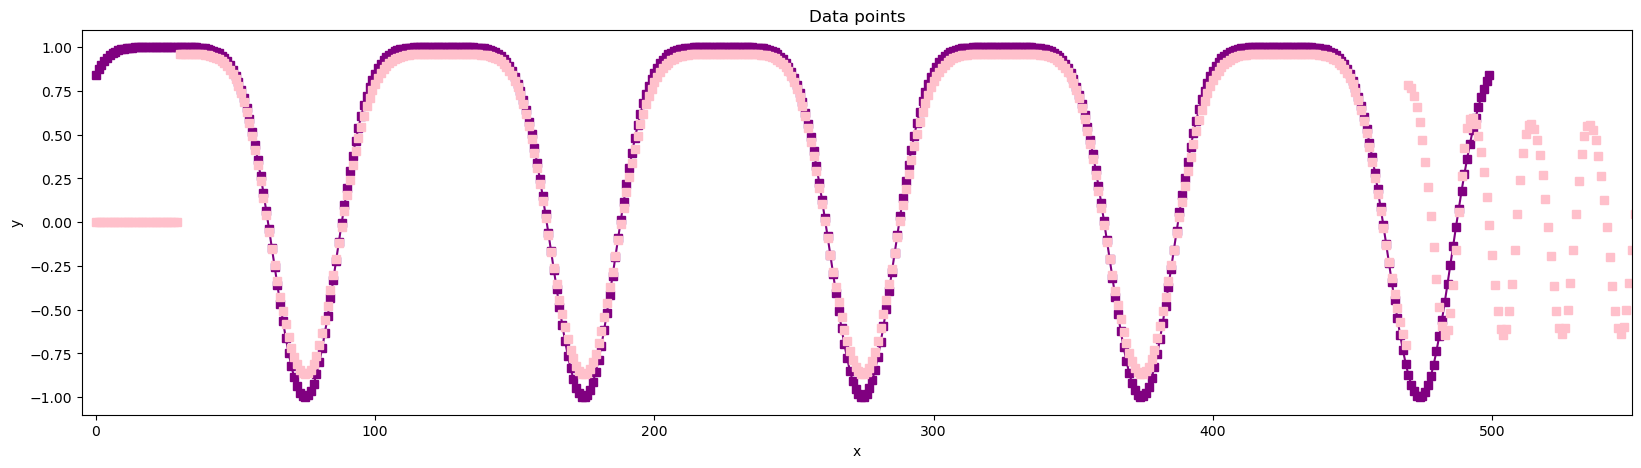

In [1155]:
new_yhat = plot_model_vs_original(model, new_loader, device='mps')
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.plot(new_data,'ks-', color='purple')
ax.plot(predicted_series,'ks', color='pink')
ax.set_title('Data points')
ax.set_xlabel('x' )
ax.set_ylabel('y' )    
ax.set_xlim([-5,N+50])